# Trayendo datos de poloniex y convirtiendolos en dataframe

In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline

# trayendo y preparando datos
df  = prepareData(pair="BTC_ETC",
                  start=string2ts("2016-08-01 00:00:00"),
                  end=string2ts("2017-09-01 00:00:00"),
                  period=3600*4)

# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil

cum_return1 = marketReturn(df[:int(len(df)*0.8)])
cum_return2 = marketReturn(df[int(len(df)*0.8):]) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 153.347185741


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2016-08-01 00:00:00,0.002897,0.00295944,0.002959,0.002875,817661.63614015,2372.676749,0.002902
2016-08-01 04:00:00,0.003106,0.00312677,0.003127,0.002897,1510932.655637,4538.289122,0.003004
2016-08-01 08:00:00,0.003440,0.00359,0.003590,0.003106,4943127.707158,16873.846935,0.003414
2016-08-01 12:00:00,0.003502,0.00356308,0.003563,0.003440,1699030.2951573,5879.148575,0.003460
2016-08-01 16:00:00,0.003480,0.00351784,0.003518,0.003502,1588124.6294147,5426.278914,0.003417


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

profit.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  w["return"] = vecReturn


Retorno del mercacdo: 153.347185741
Retorno de SMA13 VS EMA5: 219.862143691
Retorno de Precio VS SMA20: 424.786019862
Retorno de Precio VS EMA5: 516.616096581


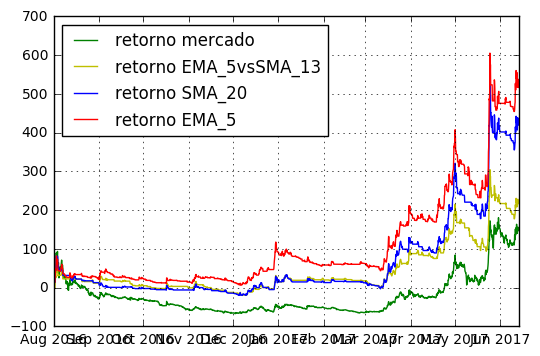

In [2]:
from strategy import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*0.8)]
wTest = w[int(len(df)*0.8):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*0.8)]
w3Test = w3[int(len(df)*0.8):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*0.8)]
w2Test = w2[int(len(df)*0.8):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*0.8)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*0.8)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*0.8)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*0.8)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()

## RSI via stockstacks

In [3]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

Retorno de estrategia ideal: 462047769.392


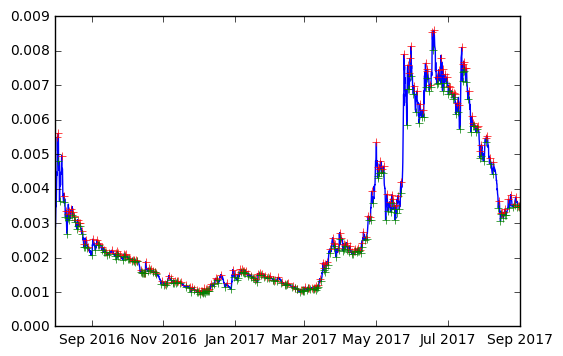

In [6]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"])

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"volumen":df["volume"],"rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],"ideal_w":w4["w"]})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(df)*0.8)]
test = data[int(len(df)*0.8):]

# Creando modelo de regresion logistica utilizando sticklearn

In [7]:
from sklearn.linear_model import LogisticRegression

# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w"
features = ["price","rsi","volumen","macd","macds","sma13ema5","price_sma20"]


logreg = LogisticRegression()

logreg.fit(train[features],train["ideal_w"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## probando modelo en otros datos

Retorno del mercacdo: -51.9731103679
Retorno de SMA13 VS EMA5: -7.7803204001
Retorno de Precio VS SMA20: -2.19802161521
Retorno de Precio VS EMA5: -15.7053465362
Retorno de ML_strategy: -1.61037999795


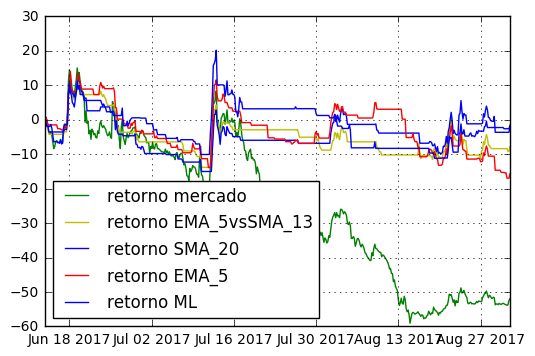

In [8]:
w_pred = logreg.predict(test[features])

w5 = pd.DataFrame(data={"w":w_pred,"price":test["price"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

print 'Retorno del mercacdo: %s'%(marketReturn2)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_strategy: %s'%(relativeReturn5*100)

plt.plot(df.index[int(len(data)*0.8):],cum_return2*100,'g', label='retorno mercado')
plt.plot(df.index[int(len(data)*0.8):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[int(len(data)*0.8):],v3Test*100,'b',label='retorno SMA_20')
plt.plot(df.index[int(len(data)*0.8):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*0.8):],v5*100,label='retorno ML')

plt.legend(loc='best')
plt.grid()